In [1]:
%matplotlib inline
# imports required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynetlogo
import numpy as np
import sys
import datetime
sys.path.append('../')

from ecohydr_mod import EcoHyd

In [2]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

yearData = get_yearly_temp("./new_temp_data.csv", 10)

In [3]:
def setUpNetLogoModel(leadFarmers, desperation, jealousy, grace):
    # think this is for the GUI idk?
    sns.set_style("white")
    sns.set_context("talk")

    # starts a NetLogo link, point the netlogo home path to where you have it installed on your machine
    netlogo = pynetlogo.NetLogoLink(
        gui=False,
        netlogo_home="/Volumes/NetLogo 6.3.0/NetLogo 6.3.0"
    )

    # loads a .nlogo model from provided path
    netlogo.load_model("./modelv3.nlogo")

    # runs the model setup command
    netlogo.command("setup")

     # sets globals
    globals = "update-globals " + str(leadFarmers) + " " + str(desperation) + " " + str(jealousy) + " " + str(grace)
    netlogo.command(globals)
    

    return netlogo

In [4]:
def reportsToDataFrame(netlogo):
    # gets field attributes and puts it in a data frame
    fieldAttributes = netlogo.report("get-info")
    sorted_list = sorted(fieldAttributes, key=lambda x: (-x[1],x[0]))
    fieldData = pd.DataFrame(columns=["who", "xcor","ycor","owner-id","implements-WSA", "owner-knows-WSA", "yield"], data=sorted_list)
    return fieldData

In [5]:
def convertWSAToNPArray(data):
    # sets bool into correct format to pass to hydrology model
    emptynp = np.empty((51,51))
    for i in range(0,51):
        for j in range(0,51):
            ycorFromIndex = i * -1 + 25
            xcorFromIndex = j - 25
            emptynp[i][j]= data.loc[(data['ycor'] == ycorFromIndex) & (data['xcor'] == xcorFromIndex)]["implements-WSA"].iloc[0]
    return emptynp

In [6]:
def convertHydrologyToDF(hydrologyArray, data):
    # method converts the hydrology model output into a pandas dataframer
    # 2 is the placeholder to multiply the biomass to get yield
    hydrologyData = data.copy()
    hydrologyData["yield"] = hydrologyArray.reshape((2601,1))
    return hydrologyData

In [7]:
#set climate configurations
current_clim={
        #------------------#
        # dry season dates #
        'canicula_start':0,
        'canicula_end':140, 
        'canicula_start_expected':0,
        'canicula_end_expected':140, 
        #----------------#
        # rainfall stats #
        # Times are all in hours.
        'mean_interstorm_wet':4*24,
        'mean_storm_wet':2*24,
        'mean_raindpth_wet':10,
        'mean_interstorm_dry':10*24,
        'mean_storm_dry':0.5*24,
        'mean_raindpth_dry':1,
        #-------------------#
        # temperature shift #
        'tempshift':np.array(365*[0.])
    }

#have two plausible versions of this that we switch between.

warm_clim={
        #------------------#
        # dry season dates #
        'canicula_start':0,
        'canicula_end':160, 
        'canicula_start_expected':0,
        'canicula_end_expected':140, 
        #----------------#
        # rainfall stats #
        # Times are all in hours.
        'mean_interstorm_wet':8*24,
        'mean_storm_wet':3*24,
        'mean_raindpth_wet':15,
        'mean_interstorm_dry':10*24,
        'mean_storm_dry':0.5*24,
        'mean_raindpth_dry':1,
        #-------------------#
        # temperature shift #
        'tempshift':np.array(365*[2.])
    }

no_desp_scen= [0,5,3, "No Desperation"]
high_jealousy_tolerance_scen = [5,10,3, "High Jealousy Tolerance"]
low_jealousy_tolerance_scen = [5,2,3, "Low Jealousy Tolerance"]



year: 0
year: 1
year: 2


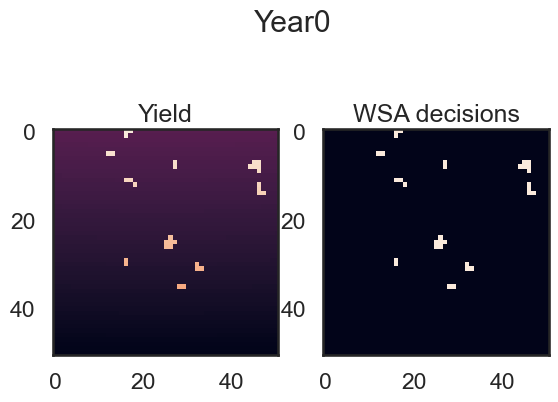

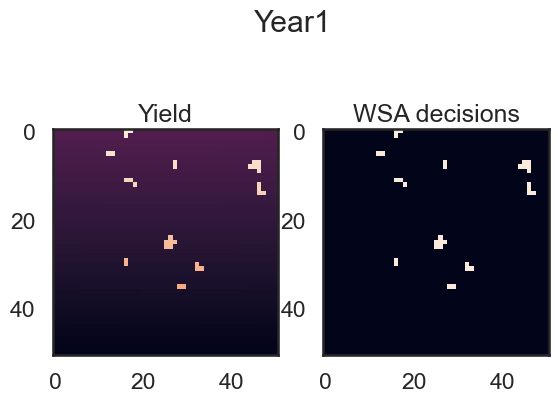

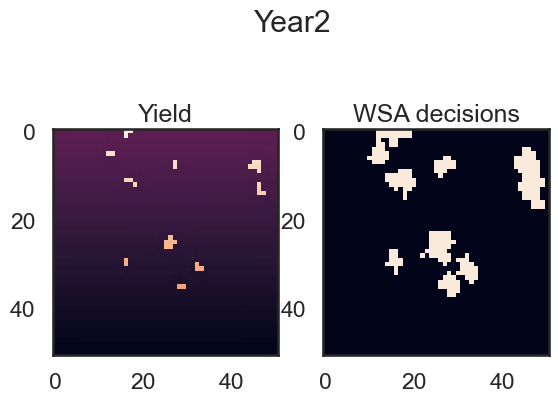

In [16]:
def fullModelRun(climate, leadFarmers, social, input_csv_path, no_of_years):
    # sets up model
    netlogo = setUpNetLogoModel(leadFarmers, social[0], social[1], social[2])

    # this will record all field attributes throughout the simulation - need to add year index to differentiate
    baseFieldData = reportsToDataFrame(netlogo)

    returnedData = baseFieldData.copy()
    
    baseFieldData["Year"] = 0

    WSA_records = []

    
    #get input temperature data
    avg, maxi, mini = get_yearly_temp(input_csv_path, no_of_years)
    avg = np.array(avg)
    maxi = np.array(maxi)
    mini = np.array(mini)

    Ecohyd_model = EcoHyd(climate, 20, 26, 23)

    #--------------------------------------------#
    # let hydrology model spin up for five years #
    for i in range(0,5):
        #just use same initial WSA array for each year
        WSA_array = convertWSAToNPArray(returnedData)
        _,_ = Ecohyd_model.stepper(WSA_array, avg[0]+climate['tempshift'], maxi[0]+climate['tempshift'], mini[0]+climate['tempshift'])

    #---------------------------------#
    # actual coupled model loop whooo #
    for year in range(0, no_of_years):
        print("year:", year)

        # converts the usingWSA bool for each field into an NP array
        WSA_array = convertWSAToNPArray(returnedData)
        WSA_records.append([WSA_array])

        biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[year]+climate['tempshift'], maxi[year]+climate['tempshift'], mini[year]+climate['tempshift'])

        #record outputs for yearly rainfall
        cum_rainfall = np.cumsum(Ecohyd_model.rain_tseries[(year)*365:(year+1)*365])[-1]

        fig, ax = plt.subplots(1, 2)
        title_string = "Year" + str(year)
        fig.suptitle(title_string)
        ax[0].imshow(np.reshape(biomass_harvest,(51,51)))
        ax[0].set_title("Yield")
        ax[1].imshow(WSA_array)
        ax[1].set_title("WSA decisions")

        returnedData.sort_values(by=['ycor', 'xcor'], ascending=[False, True], inplace=True)

        # converts the updated yields to the dataframe
        hydrologyData = convertHydrologyToDF(biomass_harvest,returnedData)
        
        # writes this new yield information to the netlogo implementation
        netlogo.write_NetLogo_attriblist(hydrologyData, "field")

        # runs one step of social model
        netlogo.command("farming-year")

        # converts field data to a df
        returnedData = reportsToDataFrame(netlogo)

        dataToRecord = returnedData.copy()
        
        dataToRecord["Year"] = year + 1

        dataToRecord["TotalYearRainfall"] = cum_rainfall

        # adds this years results to the dataframe
        baseFieldData = pd.concat([baseFieldData, dataToRecord], ignore_index=True)

    summarisedData = baseFieldData.groupby(["owner-id","Year"]).agg({'xcor':'mean','ycor':'mean','implements-WSA':'mean','owner-knows-WSA':'mean', 'yield':'sum', 'who':'count'}).reset_index()
    summarisedData.rename(columns={'owner-id':'FarmerID', 'xcor':'MeanXCor', 'ycor':'MeanYCor', 'implements-WSA':'ImplementingWSA','owner-knows-WSA':'KnowsWSA','yield':'TotalYield','who':'NumberofFields'})

    summarisedData["LeadFarmers"] = leadFarmers
    summarisedData["SocialScenario"] = social[3]
    if climate['mean_raindpth_wet'] == 10:
        summarisedData["ClimateScenario"] = "Current Climate"
    else:
        summarisedData["ClimateScenario"] = "Warm Climate"
    summarisedData["UniqueID"] = str(datetime.datetime.now())
    
    # this writes to a csv
    summarisedData.to_csv(path_or_buf="modelOutput", mode = "a", index=False, header = True)
    return summarisedData, WSA_records, biomass_harvest
    
    


# haven't got setup with globals actually working yet, manually change in the NetLogo Code
baseFieldData, WSA_records, biomass_harvest = fullModelRun(current_clim, 10, no_desp_scen,"new_temp_data.csv", 3)

In [9]:
baseFieldData.loc[(baseFieldData["implements-WSA"] == 0) & (baseFieldData["Year"] == 3) & (baseFieldData["yield"] > 30)]

,owner-id,Year,xcor,ycor,implements-WSA,owner-knows-WSA,yield,who,Lead Farmers,Social Scenario,Climate Scenario,UniqueID
3,0.0,3,5.500000,3.500000,0.0,0.0,214.608143,4,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
7,1.0,3,-6.000000,10.000000,0.0,0.0,53.897297,1,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
11,2.0,3,24.250000,14.750000,0.0,0.0,216.268226,4,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
15,3.0,3,-1.000000,-19.000000,0.0,0.0,52.782279,1,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
19,4.0,3,-0.500000,-8.000000,0.0,0.0,106.423369,2,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
...,...,...,...,...,...,...,...,...,...,...,...,...
3183,795.0,3,-20.000000,-14.000000,0.0,0.0,52.974010,1,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
3187,796.0,3,-18.666667,-15.666667,0.0,0.0,158.728205,3,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
3191,797.0,3,-6.800000,-8.600000,0.0,0.0,265.940065,5,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373
3195,798.0,3,23.428571,22.285714,0.0,0.0,380.415760,7,10,No Desperation,Warm Climate,2023-11-28 15:32:19.356373


In [17]:
baseFieldData

owner-id  Year       xcor       ycor  implements-WSA  owner-knows-WSA  \
0          0.0     0  16.500000 -23.500000             0.0              0.0   
1          0.0     1  16.500000 -23.500000             0.0              0.0   
2          0.0     2  16.500000 -23.500000             0.0              0.0   
3          0.0     3  16.500000 -23.500000             0.0              0.0   
4          1.0     0 -11.250000  -9.250000             0.0              0.0   
...        ...   ...        ...        ...             ...              ...   
3195     798.0     3   3.666667 -23.333333             0.0              0.0   
3196     799.0     0  -7.500000  -8.000000             0.0              0.0   
3197     799.0     1  -7.500000  -8.000000             0.0              0.0   
3198     799.0     2  -7.500000  -8.000000             0.0              1.0   
3199     799.0     3  -7.500000  -8.000000             0.0              1.0   

           yield  who  LeadFarmers  SocialScenario  ClimateScenario  \
0     200.000000    4           10  No Desperation  Current Climate   
1     200.430478    4           10  No Desperation  Current Climate   
2     199.271063    4           10  No Desperation  Current Climate   
3     196.349125    4           10  No Desperation  Current Climate   
4     200.000000    4           10  No Desperation  Current Climate   
...          ...  ...          ...             ...              ...   
3195  147.297559    3           10  No Desperation  Current Climate   
3196  400.000000    8           10  No Desperation  Current Climate   
3197  406.166817    8           10  No Desperation  Current Climate   
3198  403.647206    8           10  No Desperation  Current Climate   
3199  398.605286    8           10  No Desperation  Current Climate   

                        UniqueID  
0     2023-11-28 15:48:09.605207  
1     2023-11-28 15:48:09.605207  
2     2023-11-28 15:48:09.605207  
3     2023-11-28 15:48:09.605207  
4     2023-11-28 15:48:09.605207  
...                          ...  
3195  2023-11-28 15:48:09.605207  
3196  2023-11-28 15:48:09.605207  
3197  2023-11-28 15:48:09.605207  
3198  2023-11-28 15:48:09.605207  
3199  2023-11-28 15:48:09.605207  

[3200 rows x 12 columns]

In [10]:
biomass_harvest

array([ 54.44435636,  54.44491803,  54.44545581, ...,  52.53641772,
        52.53581811,  52.53519406])

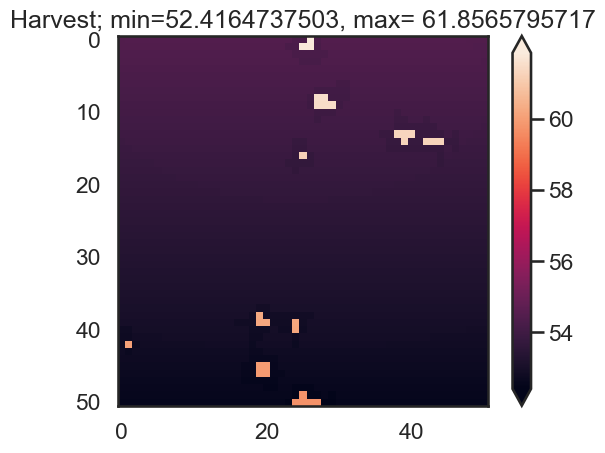

In [11]:
plt.imshow(np.reshape(biomass_harvest, (51,51)))
hmin = np.min(biomass_harvest)
hmax = np.max(biomass_harvest)
plt.title('Harvest; min='+str(hmin)+', max= ' + str(hmax))

plt.colorbar(extend = 'both')

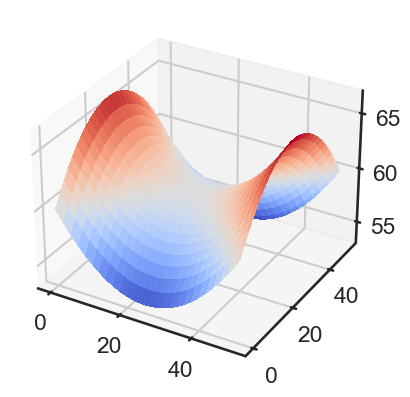

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

# Make data.
X = np.arange(0, 52, 1)
Y = np.arange(0, 52, 1)
X, Y = np.meshgrid(X, Y)
R = 0.01*(X-25)**2 - 0.01*(Y-25)**2 + 60

# Plot the surface.
surf = ax.plot_surface(X, Y, R,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)

plt.show()

In [13]:
print(baseFieldData.loc[baseFieldData["implements-WSA"] == 1].groupby(["Year"]).mean())

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
print(baseFieldData.groupby(["Year", "implements-WSA"]).mean())

TypeError: Could not convert 2023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.374248 to numeric

Text(0.5, 0.98, 'WSA field spread')

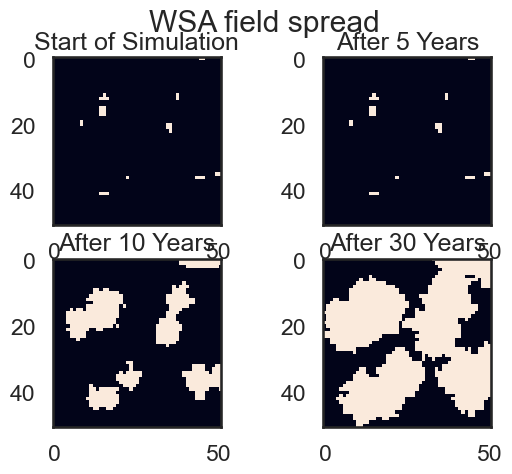

In [ ]:
fig, ax = plt.subplots(2, 2)
ax[0][0].imshow(WSA_records[0][0])
ax[0][0].set_title("Start of Simulation")
ax[0][1].imshow(WSA_records[1][0])
ax[0][1].set_title("After 5 Years")
ax[1][0].imshow(WSA_records[4][0])
ax[1][0].set_title("After 10 Years")
ax[1][1].imshow(WSA_records[9][0])
ax[1][1].set_title("After 30 Years")
plt.suptitle("WSA field spread")

In [ ]:
avgyielddata = baseFieldData.groupby(["Year", "owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"]).mean().reset_index()

nonImp = avgyielddata.loc[avgyielddata["implements-WSA"] == 0]
imp = avgyielddata.loc[avgyielddata["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["yield"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["yield"], label = "Implements WSA")
plt.legend()
plt.title("Average farmer yield by WSA type")

TypeError: Could not convert 2023-11-28 10:44:00.3742482023-11-28 10:44:00.3742482023-11-28 10:44:00.374248 to numeric

Text(0.5, 1.0, 'Number of farmers using each technique')

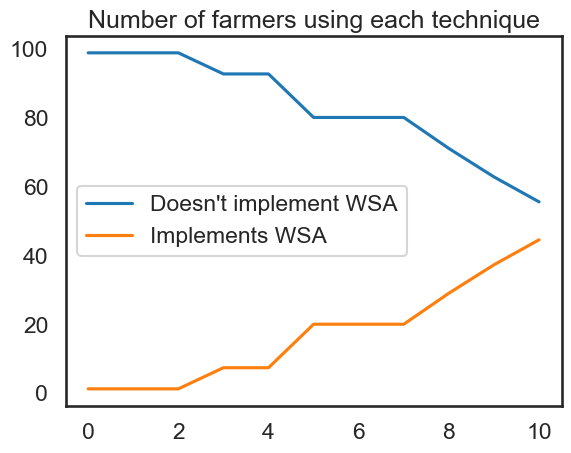

In [ ]:
proportionData = baseFieldData.groupby(["Year","implements-WSA","owner-id"]).mean().reset_index().groupby(["Year","implements-WSA"])["yield"].count().reset_index()

proportionData["percentage"] = proportionData["yield"] / 800 * 100

nonImp = proportionData.loc[proportionData["implements-WSA"] == 0]
imp = proportionData.loc[proportionData["implements-WSA"] == 1]

plt.plot(nonImp["Year"], nonImp["percentage"], label = "Doesn't implement WSA")
plt.plot(imp["Year"], imp["percentage"], label = "Implements WSA")
plt.legend()
plt.title("Number of farmers using each technique")

In [ ]:
baseFieldData

,who,xcor,ycor,owner-id,implements-WSA,yield,Year,Lead Farmers,Desperation,Jealousy,Grace Period Length
0,841.0,25.0,-13.0,645.0,0.0,50.000000,0,10,0,2,3
1,978.0,25.0,0.0,301.0,0.0,50.000000,0,10,0,2,3
2,984.0,25.0,-16.0,89.0,0.0,50.000000,0,10,0,2,3
3,1011.0,25.0,8.0,227.0,0.0,50.000000,0,10,0,2,3
4,1142.0,25.0,-19.0,727.0,0.0,50.000000,0,10,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...
28606,2991.0,-25.0,20.0,42.0,0.0,61.208856,10,10,0,2,3
28607,3177.0,-25.0,7.0,468.0,0.0,61.074106,10,10,0,2,3
28608,3182.0,-25.0,14.0,362.0,0.0,61.146991,10,10,0,2,3
28609,3234.0,-25.0,-25.0,733.0,1.0,65.307144,10,10,0,2,3
